# EDA and Preprocessing, CER

Author: Scott Yip \
Date: 28 June 2022

The abstract and information for this dataset can be accessed [here](https://www.ucd.ie/issda/data/commissionforenergyregulationcer/). In particular, we use Study Number (SN): 0012-00 - this has become a staple dataset for EED compression.

Additional information about the dataset is located in the manifest file labelled `Manifest - Smart Meter Electricity Trial Data v1.0.1.docx`.

The relevant smart meter read data is that

```
6 zipped files named File1.txt.zip to File6.txt.zip each containing 1 text file
Format of each data file: 3 columns corresponding to  
		Meter ID
		Five digit code:  
			Day code: digits 1-3 (day 1 = 1st January 2009)
			Time code: digits 4-5 (1-48 for each 30 minutes with 1= 00:00:00 – 00:29:59)
		Electricity consumed during 30 minute interval (in kWh)

```

The notable minimal preprocessing changes we'll have to make are:
* conversion of five digit code to timedate format.

We further note that we work with $30$ minute intervals.

## 1. Intro and baseline processing

### 1A. Intro

Let's perform some very quick EDA to get an idea of this dataset.

Nb: we use the `dask` library instead of `pandas` as we want to avoid out-of-memory computations. `dask` will allow us to perform on-disk processing for larger-than-memory computations (which may occur).

In [118]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import os
import dask.dataframe as dd

In [119]:
# Set folder parameters
dataset_folder = "../../dataset/raw/CERN/"

In [120]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

As the files are all separate, we'd like to use `dask` to read all the files.

Let's use `os.listdir()` to check all files (non recursively).

In [121]:
# use os.listdir() and not os.walk() as no recursive movement required
all_files = [dataset_folder + file for file in os.listdir(dataset_folder) if file[-3:] == 'txt']

print('Number of txt files: {}'.format(len(all_files)))

Number of txt files: 6


Let's read all these into using `dask`:

In [122]:
df = dd.read_csv(all_files, names=['metre_id', 'timecode', 'kwh'], sep=' ',
                dtype={'metre_id': 'int64', 'timecode': 'object', 'kwh': 'float64'})

In [123]:
df.head(3)

,metre_id,timecode,kwh
0,4597,19711,0.144
1,4597,19712,0.144
2,4597,19501,0.208


Great, now let's do the timecode conversion to a `datetime` format using the rules in the manifest:

In [124]:
def time_conversion(df, timecode='timecode'):
    
    """
    Auxiliary function to convert timecodes to date codes
    """
    
    # Implement the intial date (1/1/19)
    init_date = datetime.datetime(2009, 1, 1)
    
    # Split out the timecodes to day codes and minute codes
    day_code = df[timecode].str.slice(stop=3).astype('int64')
    minute_code = df[timecode].str.slice(start=3).astype('int64')
    
    # Note: dd.to_timedelta() does not seem to work with dd.map_partitions()
    # resorting to using pd.to_timedelta() though I believe this is slower
    
    # Add day code
    temp_date = init_date + pd.to_timedelta(day_code-1, unit='day')
    # Add minute code
    temp_date = temp_date + pd.to_timedelta(minute_code*30, unit='minute')
    # Reduce by one second to keep within same day
    temp_date = temp_date - pd.to_timedelta(1, unit='seconds')
    
    return temp_date

In [125]:
# Create timestamp column
df['timestamp'] = df.map_partitions(time_conversion, 'timecode', meta=(None, 'datetime64[ns]'))

In [126]:
# Drop timecode
# df = df.drop(labels='timecode', axis=1)

In [127]:
# Push into memory if available
df_memory = df.compute()

In [128]:
len(df_memory)

157992996

### 1B. Check readings per metre

It is understood from [Wang et al. (2020)](https://www.sciencedirect.com/science/article/pii/S0142061519318502) that there are issues with the Irish CER dataset. They used:

> Due to communication problems in data transmission, some data in Irish smart meter dataset have serious missing and error problems, we have screened 20,000 complete data records in the data set (each record contains 48 data points of the day), and used these 20,000 records as the historical data of the power company for compression.

As such, the authors above decided not to deal with the missing data - instead only choosing those meters for which all data points were complete. Let's screen ourselves to check how many of these that exist.

Let's check readings per meter:

In [129]:
readings_per_metre = df_memory.metre_id.value_counts()

<AxesSubplot:ylabel='Frequency'>

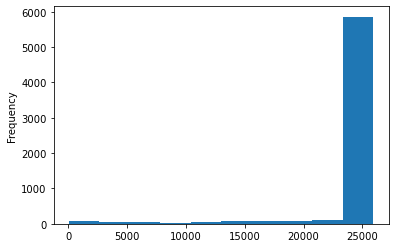

In [130]:
readings_per_metre.plot(kind='hist')

Okay - so many meters have fewer readings. Before holistically removing these, let's check the details of consecutive readings.

We leverage this [SO](https://stackoverflow.com/questions/52901387/find-group-of-consecutive-dates-in-pandas-dataframe?noredirect=1&lq=1).

In [131]:
def calculate_consecutive_intervals(df):
    
    """
    Calculate largest consecutive interval length, as well as start and end dates.
    """
    
    # Calculate consecutive counter
    df = df.sort_values(by='timestamp', ascending=True)
    df = df.reset_index(drop=True)
    df_a = (df.timestamp.shift(-1) - df.timestamp) == pd.to_timedelta(30, 'minutes')
    df_b = df_a.cumsum()
    df['cumcount'] = df_b.sub(df_b.mask(df_a).ffill().fillna(0).astype(int))
    
    # Calculate start and end date
    end = df.loc[df['cumcount'].idxmax(),'timestamp']
    start = df.loc[df['cumcount'].idxmax() - df['cumcount'].max() + 1,'timestamp']
    
    return pd.Series({'total_count': len(df), 'max_consec': df.cumcount.max() + 1, 'start': start,'end': end})

In [132]:
consec_counts = df_memory.groupby('metre_id').apply(calculate_consecutive_intervals)

<AxesSubplot:xlabel='max_consec', ylabel='Count'>

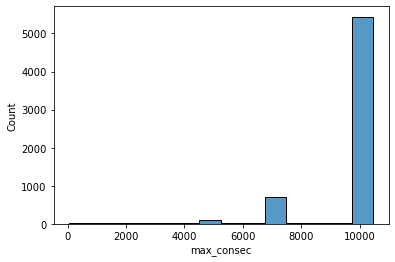

In [133]:
sns.histplot(data=consec_counts, x='max_consec')

In [134]:
consec_counts.sort_values(by='max_consec', ascending=False)

,total_count,max_consec,start,end
metre_id,,,,
7074,22802,10463,2010-03-28 01:59:59,2010-11-01 00:29:59
3936,22802,10463,2010-03-28 01:59:59,2010-11-01 00:29:59
1000,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
5112,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
5122,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
...,...,...,...,...
7426,48,48,2010-03-15 00:29:59,2010-03-15 23:29:59
5252,48,48,2010-01-31 00:29:59,2010-01-31 23:29:59
1396,48,48,2010-01-31 00:29:59,2010-01-31 23:29:59


In [135]:
consec_counts.max_consec.value_counts()[:5]

10462    5410
7344      683
4993       70
48          9
10317       6
Name: max_consec, dtype: int64

In [136]:
(consec_counts['total_count'] == consec_counts['max_consec']).sum()

113

These results above are abnormal. Given that there are approximately 25k recordings for each metre, shouldn't we be seeing substantially more than 10k consecutively. Furthermore, only 113 metres have fully consecutive recordings...

### 1C. Investigate break points

Let's investigate whether there is a recurring issue within the dataset by investigating several specific instances of the cutoffs. We write a function to print the transactions subsequent to our break points:

In [137]:
def return_surrounding_rows(indicies, padding=5):
    
    """
    Aux function to add row padding for investigation
    """
    
    return [x for x in [list(range(i-padding, i+padding+1)) for i in indicies] for x in x]

def investigate_breaks(metre_id, df, padding=5):
    
    """
    Print consecutive break points
    """
    
    # Run additional diagnostic columns (cumulative checks)
    test_single = df[df['metre_id'] == metre_id]
    test_single = test_single.sort_values('timestamp', ascending=True)
    test_single.reset_index(inplace=True, drop=True)
    test_single2 = (test_single.timestamp.shift(-1) - test_single.timestamp) == pd.to_timedelta(30, 'minutes')
    test_single3 = test_single2.cumsum()
    test_single['cumdiff'] =  (test_single.timestamp.shift(-1) - test_single.timestamp)
    test_single['cumcheck'] = test_single2
    test_single['cumulativecount'] = test_single3.sub(test_single3.mask(test_single2).ffill().fillna(0).astype(int))
    
    # Get padded indicies 
    indicies = return_surrounding_rows(test_single[test_single['cumulativecount'] == 0].index[:-1], padding) # Ignore last one as always OOB
    indicies = [i for i in indicies if i in test_single.index] # Ensure all indicies are in index (no out of bound error)
    
    return test_single.loc[indicies]

In [138]:
investigate_breaks(7074, df_memory, padding=1)

,metre_id,timecode,kwh,timestamp,cumdiff,cumcheck,cumulativecount
4991,7074,29848,2.157,2009-10-25 23:59:59,0 days 00:30:00,True,4992
4992,7074,29901,1.591,2009-10-26 00:29:59,0 days 00:00:00,False,0
4993,7074,29849,0.708,2009-10-26 00:29:59,0 days 00:30:00,True,1
4993,7074,29849,0.708,2009-10-26 00:29:59,0 days 00:30:00,True,1
4994,7074,29902,0.755,2009-10-26 00:59:59,0 days 00:00:00,False,0
4995,7074,29850,0.621,2009-10-26 00:59:59,0 days 00:30:00,True,1
12337,7074,45148,0.664,2010-03-27 23:59:59,0 days 00:30:00,True,7343
12338,7074,45201,0.766,2010-03-28 00:29:59,0 days 01:30:00,False,0
12339,7074,45204,0.656,2010-03-28 01:59:59,0 days 00:30:00,True,1


In [139]:
investigate_breaks(3936, df_memory, padding=1)

,metre_id,timecode,kwh,timestamp,cumdiff,cumcheck,cumulativecount
4991,3936,29848,0.549,2009-10-25 23:59:59,0 days 00:30:00,True,4992
4992,3936,29849,0.464,2009-10-26 00:29:59,0 days 00:00:00,False,0
4993,3936,29901,0.622,2009-10-26 00:29:59,0 days 00:30:00,True,1
4993,3936,29901,0.622,2009-10-26 00:29:59,0 days 00:30:00,True,1
4994,3936,29850,0.465,2009-10-26 00:59:59,0 days 00:00:00,False,0
4995,3936,29902,0.631,2009-10-26 00:59:59,0 days 00:30:00,True,1
12337,3936,45148,0.000,2010-03-27 23:59:59,0 days 00:30:00,True,7343
12338,3936,45201,0.000,2010-03-28 00:29:59,0 days 01:30:00,False,0
12339,3936,45204,0.000,2010-03-28 01:59:59,0 days 00:30:00,True,1


In [140]:
investigate_breaks(1000, df_memory, padding=1)

,metre_id,timecode,kwh,timestamp,cumdiff,cumcheck,cumulativecount
4991,1000,29848,0.222,2009-10-25 23:59:59,0 days 00:30:00,True,4992
4992,1000,29901,0.063,2009-10-26 00:29:59,0 days 00:00:00,False,0
4993,1000,29849,0.047,2009-10-26 00:29:59,0 days 00:30:00,True,1
4993,1000,29849,0.047,2009-10-26 00:29:59,0 days 00:30:00,True,1
4994,1000,29902,0.037,2009-10-26 00:59:59,0 days 00:00:00,False,0
4995,1000,29850,0.027,2009-10-26 00:59:59,0 days 00:30:00,True,1
12337,1000,45148,0.107,2010-03-27 23:59:59,0 days 00:30:00,True,7343
12338,1000,45201,0.024,2010-03-28 00:29:59,0 days 01:30:00,False,0
12339,1000,45204,0.024,2010-03-28 01:59:59,0 days 00:30:00,True,1
22799,1000,66948,0.057,2010-10-31 23:59:59,0 days 00:30:00,True,10461


In [141]:
investigate_breaks(5122, df_memory, padding=1)

,metre_id,timecode,kwh,timestamp,cumdiff,cumcheck,cumulativecount
4991,5122,29848,0.050,2009-10-25 23:59:59,0 days 00:30:00,True,4992
4992,5122,29849,0.115,2009-10-26 00:29:59,0 days 00:00:00,False,0
4993,5122,29901,0.056,2009-10-26 00:29:59,0 days 00:30:00,True,1
4993,5122,29901,0.056,2009-10-26 00:29:59,0 days 00:30:00,True,1
4994,5122,29850,0.071,2009-10-26 00:59:59,0 days 00:00:00,False,0
4995,5122,29902,0.116,2009-10-26 00:59:59,0 days 00:30:00,True,1
12337,5122,45148,0.120,2010-03-27 23:59:59,0 days 00:30:00,True,7343
12338,5122,45201,0.106,2010-03-28 00:29:59,0 days 01:30:00,False,0
12339,5122,45204,0.058,2010-03-28 01:59:59,0 days 00:30:00,True,1
22799,5122,66948,0.090,2010-10-31 23:59:59,0 days 00:30:00,True,10461


Okay - so the above is looking promising.

In all of our top examples (where maximum consecutive 15 minute intervals are $10463$), it appears that there are the same break points, i.e.:
* 4991, 12337, 22799

Based on the above, we can review and comment for the following break points:
* **4991**: timecode 29901 goes into timecode 29849. These are effectively the same timecode (as we are not meant to go above 48 for the last two digits) and therefore this is why it's breaking. 
* **12337**: timecode 45201 goes to timecode 45204. Missing 3 time code recordings.
* **22799**: timecode 66949 goes to 67001. Once again, same as 4991, these are the same time codes.

### 1D. Fix break points

Given that there's only a few break points (4 for each of the above) for the meters which have $10462$ and $10463$ consecutive transactions, let's just fix them:
* Overlap errors: take the average; and
* Missing errors: propogate last known value.

While these fixes are basic and do not leverage other more advanced imputation techniques (i.e., regression imputation, KNN, etc.), given the few break points these should be sufficient. As such, when implementing our fixes, we should also check to ensure that not too many break points are being fixed (i.e., if we have 500 break points, these fixes are not appropriate).

Furthermore, this should result in at least $5410$ meters worth of data with approx 25k rows each. As we will have achieved sufficient quantum (~135 million recordings), we will not use the remaining data.

pseudo  code:

if cumdiff = 0:00: change current row to average of this row and next row, remove following row \
elif cumdiff > 0:15: create all frequencies between this nad next row, let timecode = 'created', kwh = 'last known'

Firstly, let's create the subset of `df_memory` with the 5142 records with 10,462 consecutive values.

In [142]:
df_memory = df_memory.astype({'metre_id': 'object'})

In [143]:
meters_to_keep = consec_counts[consec_counts['max_consec'] == 10462].index

In [144]:
df_truncated_memory = df_memory[df_memory['metre_id'].isin(meters_to_keep)]

In [145]:
df_truncated_memory.groupby('metre_id').apply(calculate_consecutive_intervals)

,total_count,max_consec,start,end
metre_id,,,,
1000,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
1001,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
1002,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
1003,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
1004,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
...,...,...,...,...
7438,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
7439,25634,10462,2010-03-28 01:59:59,2010-10-31 23:59:59
7441,25730,10462,2010-03-28 01:59:59,2010-10-31 23:59:59


Apply averaging for same rows

In [146]:
def get_all_breaks(df):
    
    """
    Print break points for all records in the dataframe
    """
    
    for i, meter in enumerate(df.metre_id.unique()):
        
        test_single = df[df['metre_id'] == meter]
        test_single = test_single.sort_values('timestamp', ascending=True)
        test_single.reset_index(inplace=True, drop=True)
        test_single2 = (test_single.timestamp.shift(-1) - test_single.timestamp) == pd.to_timedelta(30, 'minutes')
        test_single3 = test_single2.cumsum()
        test_single['cumdiff'] =  (test_single.timestamp.shift(-1) - test_single.timestamp)
        test_single['cumcheck'] = test_single2
        test_single['cumulativecount'] = test_single3.sub(test_single3.mask(test_single2).ffill().fillna(0).astype(int))
        
        # Get indicies 
        indicies = test_single[test_single['cumulativecount'] == 0].index[:-1]
        
        test_single = test_single.loc[indicies]
        
        # Check if first
        if i != 0:
            test_multiple = pd.concat([test_multiple,test_single])
        elif i == 0:
            test_multiple = test_single
    
    return test_multiple

In [147]:
def fix_duplicate_using_avg(df):
    
    return df.groupby(['timestamp', 'metre_id']).mean().reset_index()

In [148]:
df_truncated_memory = df_truncated_memory.groupby(['timestamp', 'metre_id']).mean().reset_index()

In [149]:
df_truncated_memory.groupby('metre_id').apply(calculate_consecutive_intervals)

,total_count,max_consec,start,end
metre_id,,,,
1000,25726,13389,2010-03-28 01:59:59,2010-12-31 23:29:59
1001,25726,13389,2010-03-28 01:59:59,2010-12-31 23:29:59
1002,25726,13389,2010-03-28 01:59:59,2010-12-31 23:29:59
1003,25726,13389,2010-03-28 01:59:59,2010-12-31 23:29:59
1004,25726,13389,2010-03-28 01:59:59,2010-12-31 23:29:59
...,...,...,...,...
7438,25726,13389,2010-03-28 01:59:59,2010-12-31 23:29:59
7439,25630,12337,2009-07-14 00:29:59,2010-03-27 23:59:59
7441,25726,13389,2010-03-28 01:59:59,2010-12-31 23:29:59


duplicate fixing

In [150]:
def reindex_by_date(subset_df):
    
    """
    Reindex to every 30 minutes (fills empties) - function to be used
    WITHIN the groupby operation.
    """
    
    subset_df = subset_df.set_index('timestamp')
    dates = pd.date_range(subset_df.index.min(), subset_df.index.max(), freq='30min')
    return subset_df.reindex(dates, method='ffill', limit=48) # one day max forward prop...TODO: investigate this

def fix_missing_dates(df):
    
    df = df.groupby('metre_id').apply(reindex_by_date).reset_index(level=1).reset_index(drop=True)
    
    df = df.rename({'level_1': 'timestamp'}, axis=1)
    
    return df

In [151]:
df_truncated_memory2 = fix_missing_dates(df_truncated_memory)

In [152]:
df_truncated_memory2.groupby('metre_id').apply(calculate_consecutive_intervals)

,total_count,max_consec,start,end
metre_id,,,,
1000.0,25728,25728,2009-07-14 00:29:59,2010-12-31 23:29:59
1001.0,25728,25728,2009-07-14 00:29:59,2010-12-31 23:29:59
1002.0,25728,25728,2009-07-14 00:29:59,2010-12-31 23:29:59
1003.0,25728,25728,2009-07-14 00:29:59,2010-12-31 23:29:59
1004.0,25728,25728,2009-07-14 00:29:59,2010-12-31 23:29:59
...,...,...,...,...
7438.0,25728,25728,2009-07-14 00:29:59,2010-12-31 23:29:59
7439.0,25680,24432,2009-07-14 00:29:59,2010-12-04 23:29:59
7441.0,25728,25728,2009-07-14 00:29:59,2010-12-31 23:29:59


In [153]:
df_truncated_memory2.shape

(138801524, 3)

Quickly check consec intervals

In [154]:
final_consec_intervals = df_truncated_memory2.groupby('metre_id').apply(calculate_consecutive_intervals)

sum(final_consec_intervals['total_count'] != final_consec_intervals['max_consec'])

218

No point in fixing these now given quantum of data anyway, so let's remove.

In [155]:
df_truncated_memory2 = df_truncated_memory2[~df_truncated_memory2['metre_id'].isin(final_consec_intervals[final_consec_intervals['total_count'] != final_consec_intervals['max_consec']].index)]

Check after fix

In [156]:
final_consec_intervals = df_truncated_memory2.groupby('metre_id').apply(calculate_consecutive_intervals)

final_consec_intervals[final_consec_intervals['total_count'] != final_consec_intervals['max_consec']]

,total_count,max_consec,start,end
metre_id,,,,


FINALLY, we evaluate that all points start at 00:29 and end at 23:59 - that way we have exactly 48 points a day FOR ALL DAYS AND ALL METERS.

Last thing, ensure that all points start at 12am effectively for all meters

In [157]:
# Evaluate the general starting point

starting_time = df_truncated_memory2.groupby('metre_id').timestamp.min()[1000]

starting_time

Timestamp('2009-07-14 00:29:59')

In [158]:
sum(df_truncated_memory2.groupby('metre_id').timestamp.min() != starting_time) # Number of meters not starting at the starting point identified above

12

Okay so there are 118 metres which don't start at the right point, let's quickly check them and reset them just to start at the closest day

In [159]:
df_truncated_memory2.groupby('metre_id').timestamp.min()[df_truncated_memory2.groupby('metre_id').timestamp.min() != starting_time]

metre_id
1924.0   2009-10-21 00:29:59
2557.0   2009-08-24 00:29:59
2657.0   2009-08-06 00:29:59
2783.0   2010-03-03 00:29:59
2845.0   2009-07-15 00:29:59
4277.0   2009-07-28 14:29:59
5320.0   2009-11-20 00:29:59
6521.0   2009-07-15 00:29:59
6650.0   2009-07-25 00:29:59
6971.0   2009-07-25 00:29:59
7174.0   2009-12-16 00:29:59
7212.0   2009-09-24 00:29:59
Name: timestamp, dtype: datetime64[ns]

Great, even if they don't start on that date we noted before, at least the 118 meters still do start at midnight except for meter 4277. We will fix this.

Let's see how the end looks (this should be cleaner as we split on this for the train/test split).

For this one, we take learnings from the above checking, and just really need to check if they end at midnight.

In [160]:
sum(df_truncated_memory2.groupby('metre_id').timestamp.max().dt.time != datetime.time(23, 59, 59))

0

0 dastardly meters! Let's write a function which will fix both!

In [161]:
df_truncated_memory2.groupby('metre_id').timestamp.max()[df_truncated_memory2.groupby('metre_id').timestamp.max().dt.time != datetime.time(23, 59, 59)]

Series([], Name: timestamp, dtype: datetime64[ns])

In [162]:
def retractend_protractstart_midnight(group_df):
    
    """
    GROUPBY function: Retracts all meters to most recent midnights
    """
    
    # Check if we even need to make modifications
    if group_df.timestamp.max().time() == datetime.time(23, 59, 59) and group_df.timestamp.min().time() == datetime.time(0, 29, 59):
        return group_df
    
    #################################################################################################################################
    ##### FIX FIRST DAY
    
    if group_df.timestamp.min().time() != datetime.time(0, 29, 59):
    
        # Grab the latest day
        first_day = group_df.timestamp.min().date()

        # Evaluate from above, what to filter on (i.e., midnight before last day)
        filter_date_start = pd.to_datetime(first_day) + pd.to_timedelta('1 day') + pd.to_timedelta('0 hours 29 minutes 59 seconds')

        group_df = group_df[group_df['timestamp'] >= filter_date_start]
    
    #################################################################################################################################
    ##### FIX LAST DAY
    
    if group_df.timestamp.max().time() != datetime.time(23, 59, 59):
    
        # Grab the latest day
        last_day = group_df.timestamp.max().date()

        # Evaluate from above, what to filter on (i.e., midnight before last day)
        filter_date_end = pd.to_datetime(last_day) - pd.to_timedelta('1 day') + pd.to_timedelta('23 hours 59 minutes 59 seconds')

        group_df = group_df[group_df['timestamp'] <= filter_date_end]
    
    return group_df

In [163]:
df_truncated_memory2 = df_truncated_memory2.groupby('metre_id').apply(retractend_protractstart_midnight).reset_index(level = 1).drop(['level_1', 'metre_id'], axis=1).reset_index()

So sense check it, we should mod 48 exactly.

In [164]:
def check_mod_48(group_df):
    
    days = (group_df.timestamp.max().date() - group_df.timestamp.min().date()).days + 1
    no_records = len(group_df)
    expected_records = days * 48
    
    return no_records == expected_records
    

df_truncated_memory2.groupby('metre_id').apply(func=check_mod_48)

metre_id
1000.0    True
1001.0    True
1002.0    True
1003.0    True
1004.0    True
          ... 
7437.0    True
7438.0    True
7441.0    True
7442.0    True
7443.0    True
Length: 5192, dtype: bool

In [165]:
sum(df_truncated_memory2.groupby('metre_id').apply(func=check_mod_48))

5192

Nice. Now we have a very pretty dataset with 5192 meters!

### Zero Checking

In [166]:
print('Percentage of 0s: {:.2f}%'.format(sum(df_truncated_memory2.kwh == 0) / len(df_truncated_memory2)* 100))

Percentage of 0s: 0.95%


Ok so quite a few, let's see if they pertain to certain IDs (i.e., certain meters broken), as we can filter out the IDs instead of filtering out just solo days.

In [167]:
def count_zeroes(subset_df):
    
    """Counts zeroes per groupby subset"""
    
    return pd.Series((sum(subset_df.kwh == 0), len(subset_df),
                        sum(subset_df.kwh == 0) / len(subset_df) * 100),
                        index = ['zeroes', 'records', 'pct'])

df_zeroes = df_truncated_memory2.groupby('metre_id').apply(count_zeroes)

<AxesSubplot:xlabel='pct', ylabel='Density'>

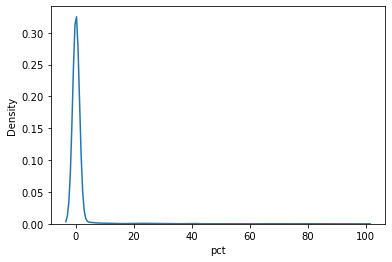

In [168]:
sns.kdeplot(data=df_zeroes, x='pct')

Let's get an exact idea of the numbers

In [169]:
pct_range = [0.1, 0.5, 1, 2, 5, 10]
total_records = sum(df_zeroes.records)

print('Total number of meters:\t\t {}'.format(len(df_zeroes)))
print('-------------------------------------\n')

for i in pct_range:
    
    print('# greater than {:.2f}% zeroes:\t {}'.format(i, len(df_zeroes[df_zeroes.pct > i])))
    print('Records to be removed:\t\t {}'.format(int(sum(df_zeroes[df_zeroes.pct > i].records))))
    print('Pct Records to be removed:\t {:.2f}%\n'.format(sum(df_zeroes[df_zeroes.pct > i].records) / total_records))

Total number of meters:		 5192
-------------------------------------

# greater than 0.10% zeroes:	 775
Records to be removed:		 19917984
Pct Records to be removed:	 0.15%

# greater than 0.50% zeroes:	 266
Records to be removed:		 6835152
Pct Records to be removed:	 0.05%

# greater than 1.00% zeroes:	 228
Records to be removed:		 5857488
Pct Records to be removed:	 0.04%

# greater than 2.00% zeroes:	 196
Records to be removed:		 5034912
Pct Records to be removed:	 0.04%

# greater than 5.00% zeroes:	 149
Records to be removed:		 3825696
Pct Records to be removed:	 0.03%

# greater than 10.00% zeroes:	 113
Records to be removed:		 2899488
Pct Records to be removed:	 0.02%



Based on the above, if we remove all meters with with greater than 0.5% zeroes, then we will only lose 0.05% of total data which would appear to be a reasonable trade-off.

Let's do that.

In [170]:
zero_meters_to_be_removed = df_zeroes[df_zeroes.pct > 0.5].index

In [171]:
# Remove of meters with too many zeroes
df_truncated_memory2 = df_truncated_memory2[~df_truncated_memory2.metre_id.isin(zero_meters_to_be_removed)]

TRAIN TEST SPLIT

Let's also train test split it now. 95%, 5% based on timeline (as meters doesn't really make sense, unless if we're talking about from geographic aggregation at the DCU level? Possible, but this is simpler).

In [173]:
timespan = df_truncated_memory2['timestamp'].max() - df_truncated_memory2['timestamp'].min()
timespan

Timedelta('535 days 23:30:00')

Okay, in total there are 535 days. A 95/5 split would result in: 508 days in train and 27 days in split.

As a result let's work out that day to split on:

In [178]:
(timespan * .95).days

509

In [181]:
df_truncated_memory2['timestamp'].min() + pd.to_timedelta('{} days'.format((timespan * .95).days))

Timestamp('2010-12-05 00:29:59')

Of course, let's split exactly on 12am to make it simpler, even if we don't end up using that as the cut-off in the future.

In [111]:
df_train = df_truncated_memory2[df_truncated_memory2['timestamp'] < pd.to_datetime('2010-12-04 00:00:01')]
df_test = df_truncated_memory2[df_truncated_memory2['timestamp'] >= pd.to_datetime('2010-12-04 00:00:01')]

In [112]:
len(df_train)

120039888

In [113]:
len(df_test)

6521904

In [114]:
len(df_test) / len(df_train)

0.054331140328954655

Most importantly check if mod 48:

In [115]:
len(df_train) % 48

0

In [116]:
len(df_test) % 48

0

NICE!

Time to finally export and save this.

In [117]:
df_train.to_csv('../../dataset/interim/cern_train.csv', index=False)
df_test.to_csv('../../dataset/interim/cern_test.csv', index=False)

Nb: The results from this dataset are incredibly poor indicating some error with the data. We revisit `1.5.-cern-preprocessing-revisit.ipynb`.